MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

Source dataset: Elevation1 - Mashhad, Iran

Elevation1 DSM + Pléiades Ortho 0.5m pan-sharpened (Orthoimage included)

https://www.intelligence-airbusds.com/en/9317-sample-imagery-detail?product=18896&keyword=&type=366

In [1]:
from osgeo import gdal
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

In [3]:
# select work area
def crop_area(raster):
    return raster.sel(x=slice(730000,730500),y=slice(4012000, 4011500))
def crop_sample(raster):
    return raster.sel(x=slice(730000,730100),y=slice(4011700,4011600))

In [4]:
def plot_fractality(ax, data):
    ax.loglog(data.r, data, base=2, label='Calculated')
    ax.set_xlabel('Wavelength, m', fontsize=18)

    ax.axes.get_yaxis().set_visible(False)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    res = linregress(np.log2(data.r), np.log2(data))
    ax.plot(data.r, 2**(res.intercept + res.slope*np.log2(data.r)), 'r', label=f'Fitted R²={res.rvalue**2:.2f}', ls='--')

    ax.legend(fontsize=18)

    fractality = 1000*np.round((3 - (res.slope/2)),1)
    return fractality

### Load DEM

In [5]:
# DEM image
dem = crop_area(xr.open_rasterio("data/Mashhad-DEM.tif")[0])
del dem.attrs['units']
dem

<xarray.DataArray (y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 4.012e+06 4.012e+06 4.012e+06 ... 4.012e+06 4.012e+06
  * x        (x) float64 7.3e+05 7.3e+05 7.3e+05 ... 7.305e+05 7.305e+05
Attributes:
    transform:      (1.0, 0.0, 730000.0, 0.0, -1.0, 4012000.0)
    crs:            +init=epsg:32640
    res:            (1.0, 1.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

### Load orthophoto image

In [6]:
# orthophoto image 0.5m for the same area
img = crop_area(xr.open_rasterio("data/7289-40126_Mashhad.tif")[0])

### Calculate spatial spectrum components

In [7]:
# check spatial components, [m]
gammas = np.arange(1,128)

img_power = xr.DataArray([raster_filter_range(img, g-1, g+1).std() for g in gammas],
                          coords=[gammas],
                          dims=['r'])
dem_power = xr.DataArray([raster_filter_range(dem, g-1, g+1).std() for g in gammas],
                          coords=[gammas],
                          dims=['r'])

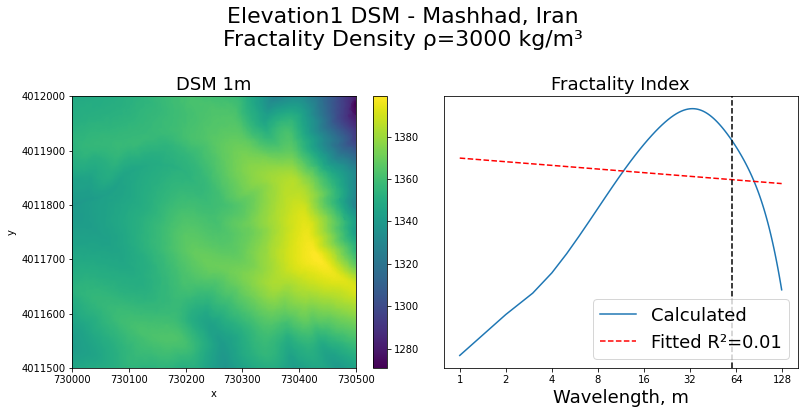

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dem.plot(ax=ax1)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title('DSM 1m', fontsize=18)

dem_fractality = plot_fractality(ax2, dem_power)
ax2.set_title('Fractality Index', fontsize=18)
ax2.axvline(x=60, ymin=0, ymax=1, color = 'black', ls='--', alpha=1)

plt.suptitle(f"Elevation1 DSM - Mashhad, Iran\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
#plt.savefig('Elevation1 DSM - Mashhad, Iran.jpg', dpi=150)
plt.show()

In [9]:
# check spatial components, [m]
gammas = np.arange(60,128)

dem_power = xr.DataArray([raster_filter_range(dem, g-1, g+1).std() for g in gammas],
                          coords=[gammas],
                          dims=['r'])

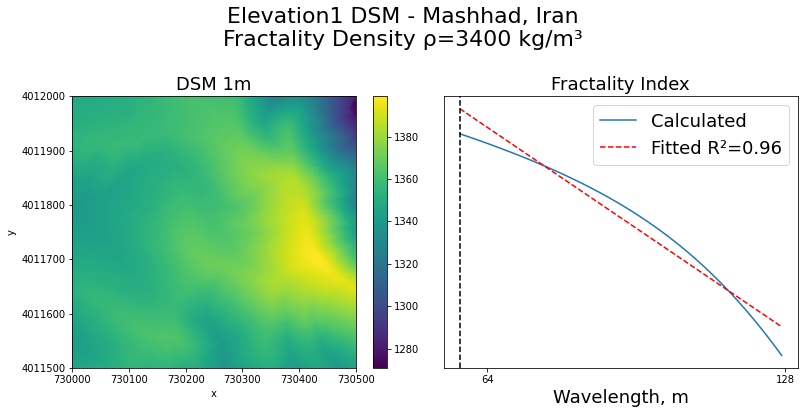

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dem.plot(ax=ax1)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title('DSM 1m', fontsize=18)

dem_fractality = plot_fractality(ax2, dem_power)
ax2.set_title('Fractality Index', fontsize=18)
ax2.axvline(x=60, ymin=0, ymax=1, color = 'black', ls='--', alpha=1)

plt.suptitle(f"Elevation1 DSM - Mashhad, Iran\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
#plt.savefig('Elevation1 DSM - Mashhad, Iran.jpg', dpi=150)
plt.show()

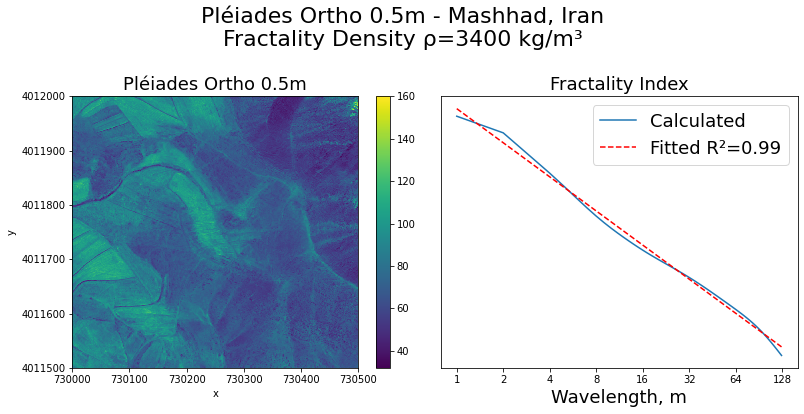

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

img.plot(ax=ax1)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title('Pléiades Ortho 0.5m', fontsize=18)

img_fractality = plot_fractality(ax2, img_power)
ax2.set_title('Fractality Index', fontsize=18)

plt.suptitle(f"Pléiades Ortho 0.5m - Mashhad, Iran\nFractality Density ρ={img_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
#plt.savefig('Pléiades Ortho 0.5m - Mashhad, Iran.jpg', dpi=150)
plt.show()